In [1]:
import cv2
import matplotlib.pyplot as plot
import numpy 
import math
import time         

grey_image="crayons_mosaic.bmp"
colored_image="crayons.jpg"

##float to get the float values
##float32 instead of float64 as median takes float32
##maximum pixel value(for any one channel) for dividing the value to avoid overflow
pix_max=numpy.iinfo(numpy.uint8).max

##input image
input_img=cv2.imread(grey_image)
##cv2.imshow("Input",input_img)
blue,green,red=cv2.split(input_img) 
rows,cols,_=input_img.shape

In [2]:
def sq_diff(org,out):
    org=org/pix_max
    out=out/pix_max
    result=(org-out)*(org-out)
    return result

In [3]:
def print_Compare(out_img,part):
    ##actual image
    actual_img=cv2.imread(colored_image)
    ##cv2.imshow("Actual image",actual_img)
    plot.imshow(actual_img)
    plot.title("Actual image")
    plot.show()
    
    ##output image
    out_blue,out_green,out_red=cv2.split(out_img)
    out_img=numpy.uint8(out_img)
    cv2.imwrite("output_image.jpg",out_img)
    ##cv2.imshow("OUTPUT image",out_img)
    plot.imshow(out_img)
    plot.title("OUTPUT image")
    plot.show()
        
    ##compare
    actual_img=numpy.float32(actual_img)
    original_b,original_g,original_r=cv2.split(actual_img)
    channel_diff=numpy.float32(actual_img)
    sum_img=cv2.cvtColor(actual_img, cv2.COLOR_BGR2GRAY) 
    avg_sum=0
    for i in range(rows):
        for j in range(cols):
            b=sq_diff(original_b[i,j],out_blue[i,j])
            g=sq_diff(original_g[i,j],out_green[i,j])
            r=sq_diff(original_r[i,j],out_red[i,j])
            channel_diff[i,j]=numpy.array([math.sqrt(b)*255,math.sqrt(g)*255,math.sqrt(r)*255])
            sum_img[i,j]=(math.sqrt(r+g+b)*pix_max)
            avg_sum=avg_sum+sum_img[i,j]
    print("AVG-SUM",(avg_sum/(rows*cols)))
    sum_img=numpy.uint8(sum_img)
    channel_diff=numpy.uint8(channel_diff)
    ##cv2.imshow("Gray Scale Noise "+part,sum_img)
    cv2.imwrite("Gray_Scale_Noise_"+part+".jpg",sum_img)
    plot.imshow(sum_img)
    plot.title("Gray Scale Noise "+part)
    plot.show()
    ##cv2.imshow("3-Channel Noise "+part,channel_diff)
    cv2.imwrite("3_Channel_Noise_"+part+".jpg",channel_diff)
    plot.imshow(channel_diff)
    plot.title("3-Channel Noise "+part)
    plot.show()

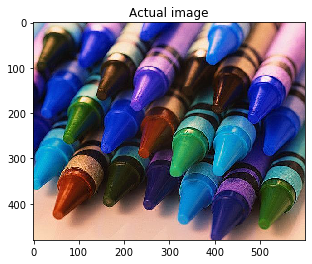

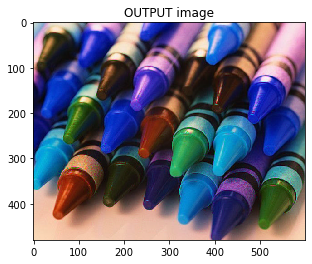

AVG-SUM 6.820550445368927


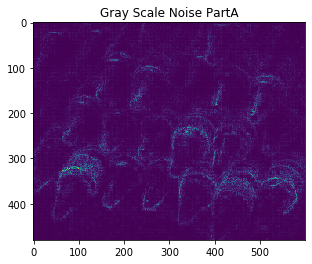

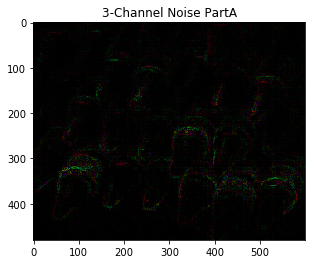

In [4]:
#####################-----------------------------Part A
##masking and filtering
##blue
blue=numpy.float32(blue)
for row in range(0,rows):
    if row%2!=0:
        blue[row][:]=0
    else:
        blue[row][1::2]=0

##kernel
##two neighbours 0.5 each sum to 1
##four neighbours 0.25 each sum to 1
##A | B | C
##D | E | F
##G | H | I
##
##E=1/2(D+F)=1/2(B+H)
##D=1/2(A+G)
##F=1/2(C+I)
##E=1/4(A+C+G+I)
kernel_blue=numpy.array([[0.25,0.5,0.25],
                         [0.5,1,0.5],
                         [0.25,0.5,0.25]])
cv2.filter2D(blue,-1,kernel_blue,blue)

##red
red=numpy.float32(red)
for row in range(0,rows):
    if row%2==0:
        red[row][::2]=0
    else:
        red[row][1::2]=0
        
##kernel
##sum of the given neighbours in the image leads to 0.25 each
##tried increasing values for other neighbours but increasing the average error. 
kernel_red=numpy.array([[0,0.25,0],
                        [0.25,1,0.25],
                        [0,0.25,0]])
cv2.filter2D(red,-1,kernel_red,red)


##green
green=numpy.float32(green)
for row in range(0,rows):
    if row%2==0:
        green[row][:]=0
    else:
        green[row][::2]=0
        
##kernel same as blue
##tried only with given 4 neighbours as given in image but this kernel gives better values
kernel_green=numpy.array([[0.25,0.5,0.25],
                          [0.5,1,0.5],
                          [0.25,0.5,0.25]])
cv2.filter2D(green,-1,kernel_green,green)  

output_img=cv2.merge((blue,green,red))
print_Compare(output_img,"PartA")

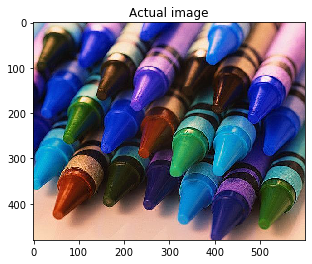

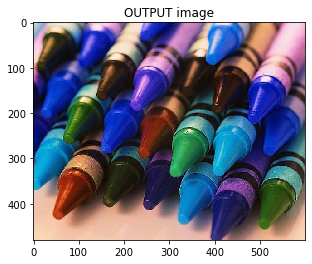

AVG-SUM 5.812559784316687


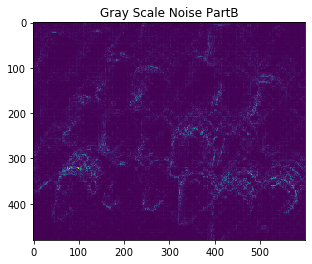

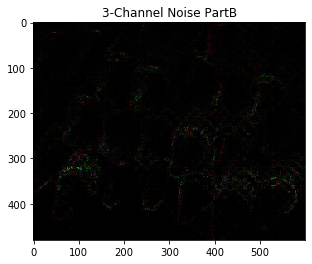

In [5]:
#####################-----------------------------Part B
green=numpy.true_divide(green,pix_max)
blue=numpy.true_divide(blue,pix_max)
red=numpy.true_divide(red,pix_max)

green=numpy.subtract(green,red)
blue=numpy.subtract(blue,red)

##kernel size
##for channel 1,3,4....kernel size 3,5
##for kernel size 5, avg error increases when compared to kernel size 3
green=cv2.medianBlur(green, 3) 
blue=cv2.medianBlur(blue, 3) 

green=numpy.add(green,red)
blue=numpy.add(blue,red)

green=green * pix_max
blue=blue * pix_max
red=red * pix_max
    
##additional over and underflow
for row in range(rows):
    for col in range(cols):
        if green[row][col]>=255:
            green[row][col]=255
        elif green[row][col]<=0:
            green[row][col]=0
        if blue[row][col]>=255:
            blue[row][col]=255
        elif blue[row][col]<=0:
            blue[row][col]=0
    
output_img=cv2.merge((blue,green,red))
print_Compare(output_img,"PartB")